In [53]:
using ReinforcementLearning, ReinforcementLearningEnvironments, RLIntro.MountainCar

Note that the `MountainCar` in the `RLIntro` is a slightly different different from the one in `ReinforcementLearningEnvironments`.

In [54]:
using Plots

In [75]:
using StatsBase

In [55]:
env = MountainCar.MountainCarEnv()

RLIntro.MountainCar.MountainCarEnv(-0.5064038798841627, 0.0, MultiContinuousSpace{(2,),1}([-1.2, -0.07], [0.5, 0.07]), DiscreteSpace{Int64}(1, 3, 3))

In [56]:
obs_space = observation_space(env)

MultiContinuousSpace{(2,),1}([-1.2, -0.07], [0.5, 0.07])

In [57]:
ns, na = length(observation_space(env)), length(action_space(env))

(2, 3)

In [58]:
ntilings = 8
ntiles = 8
tiling = Tiling(Tuple(range(l, step=(h-l)/ntiles, length=ntiles+2) for (l, h) in zip(obs_space.low, obs_space.high)))
offset = (obs_space.high .- obs_space.low) ./ (ntiles * ntilings)
tilings = [tiling - offset .* (i-1) for i in 1:ntilings]

8-element Array{Tiling{2,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}},1}:
 Tiling{2,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}((-1.2:0.2125:0.7125, -0.07:0.0175:0.0875), [1 10 … 64 73; 2 11 … 65 74; … ; 8 17 … 71 80; 9 18 … 72 81])                 
 Tiling{2,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}((-1.2265625:0.2125:0.6859375, -0.0721875:0.0175:0.0853125), [1 10 … 64 73; 2 11 … 65 74; … ; 8 17 … 71 80; 9 18 … 72 81])
 Tiling{2,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}((-1.253125:0.2125:0.659375, -0.074375:0.0175:0.083125), [1 10 … 64 73; 2 11 … 65 74; … ; 8 17 … 71 80; 9 18 … 72 81])    
 Tiling{2,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}((-1.2796875:0.2125:0.6328125, -0.0765625:0.0175:0.0809375), [1 10 … 64 73; 2 11 … 65 74; … ; 8 17 … 71 80; 9 18 … 72 81])
 Tiling{2,StepRangeLen{Float64,Base.Tw

In [59]:
TilingPreprocessor(tilings)(obs_space.low), TilingPreprocessor(tilings)(obs_space.high)

([1, 1, 1, 1, 1, 1, 1, 1], [81, 81, 81, 81, 81, 81, 81, 81])

In [60]:
using SparseArrays
struct ToSparseMatrixPreprocessor <: AbstractPreprocessor
    m::Int
    n::Int
end

(p::ToSparseMatrixPreprocessor)(xs::Vector{Int}) = sparse(1:length(xs), xs, ones(length(xs)), p.m, p.n)

In [61]:
(POSITION_MIN, VELOCITY_MIN), (POSITION_MAX, VELOCITY_MAX) = obs_space.low, obs_space.high

([-1.2, -0.07], [0.5, 0.07])

In [62]:
function create_env_agent(α=2e-4, n=0)
        env = WrappedEnv(
        env=MountainCar.MountainCarEnv(),
        preprocessor=Chain(TilingPreprocessor(tilings), ToSparseMatrixPreprocessor(ntilings, (ntiles+1)^2)), 
    )

    agent = Agent(
        π=QBasedPolicy(
            learner=TDLearner(
                approximator=LinearQApproximator(zeros(ntilings,(ntiles+1)^2, na)),
                optimizer=Descent(α),
                n=n
            ),
            selector=EpsilonGreedySelector(0.)
        ),
        buffer=episode_RTSA_buffer(;state_eltype=SparseMatrixCSC{Float64,Int64})
    )

    env, agent
end

create_env_agent (generic function with 3 methods)

In [63]:
function show_approximation(n)
    env, agent = create_env_agent()
    run(agent, env, StopAfterEpisode(n))
    [agent.π.learner.approximator(env.preprocessor([p, v])) |> maximum
        for p in range(POSITION_MIN, stop=POSITION_MAX, length=40),
            v in range(VELOCITY_MIN, stop=VELOCITY_MAX, length=40)]
end

show_approximation (generic function with 1 method)

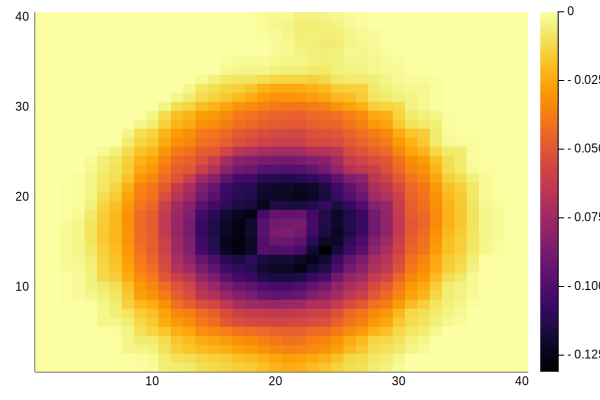

In [64]:
heatmap(show_approximation(1))

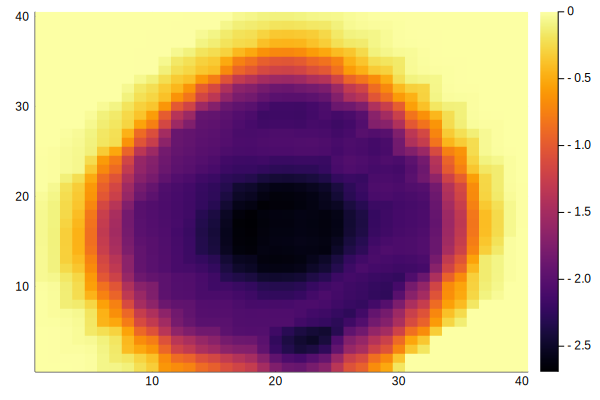

In [65]:
heatmap(show_approximation(12))

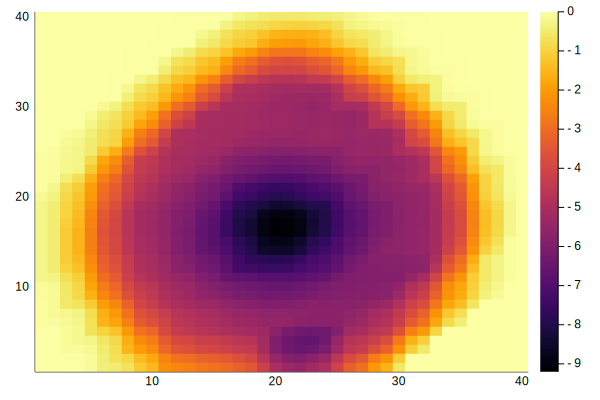

In [66]:
heatmap(show_approximation(104))

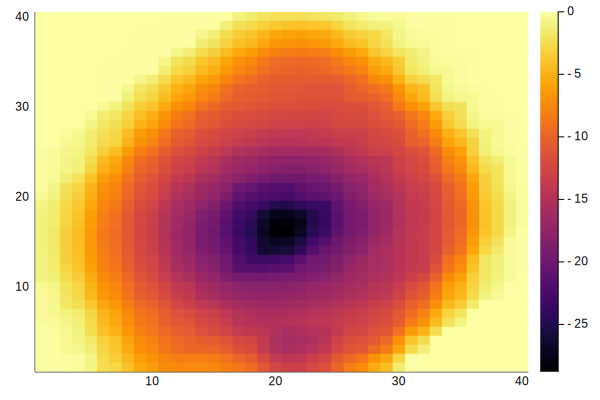

In [67]:
heatmap(show_approximation(1000))

Progress:  25%|███████████                              |  ETA: 0:00:00
4m  TRAINING/EPISODE:  0
Progress:  58%|████████████████████████                 |  ETA: 0:00:00
4m  TRAINING/EPISODE:  0
Progress:  87%|████████████████████████████████████     |  ETA: 0:00:00
4m  TRAINING/EPISODE:  0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  TRAINING/EPISODE:  0


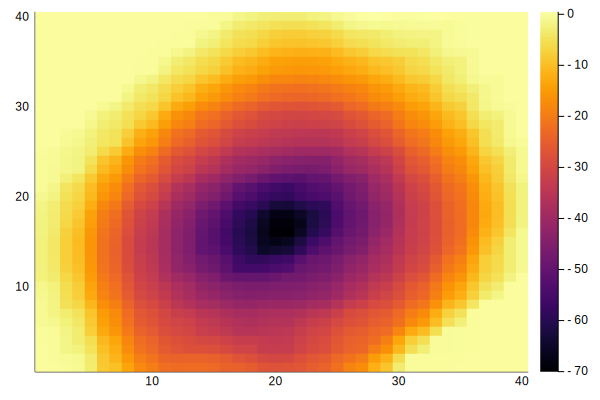

In [68]:
heatmap(show_approximation(9000))

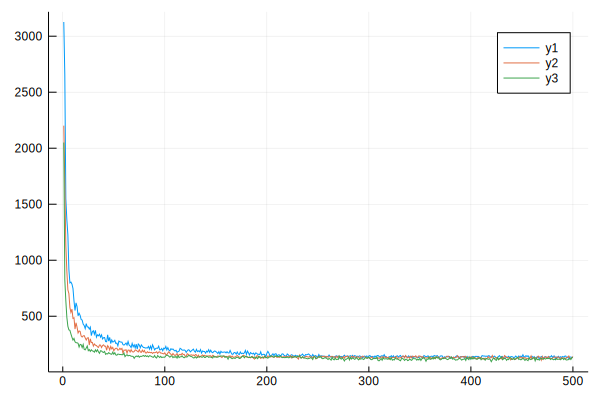

In [74]:
p = plot(legend=:topright)
n_runs = 10  # about 2 seconds per run, quite slow here, need revisit
for α in [0.1/8, 0.2/8, 0.5/8]
    avg_steps_per_episode = zeros(500)
    for _ in 1:n_runs
        env, agent = create_env_agent(α)
        hook = StepsPerEpisode()
        run(agent, env, StopAfterEpisode(500; is_show_progress=false);hook=hook)
        avg_steps_per_episode .+= hook.steps
    end
    plot!(p, avg_steps_per_episode ./ n_runs)
end
p

In [76]:
function run_once(α, n)
    env, agent = create_env_agent(α, n)
    hook = StepsPerEpisode()
    run(agent, env, StopAfterEpisode(50), hook=hook)
    mean(hook.steps)
end

run_once (generic function with 1 method)

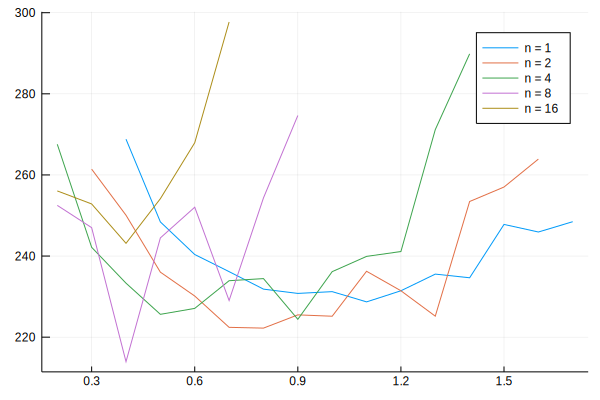

In [88]:
p = plot(legend=:topright)
for (A, n) in [(0.4:0.1:1.7, 1), (0.3:0.1:1.6, 2), (0.2:0.1:1.4, 4), (0.2:0.1:0.9, 8), (0.2:0.1:0.7, 16)]
    plot!(p, A, [mean(run_once(α/8, n) for _ in 1:5) for α in A], label="n = $n")
end
p